# ACIC 7 example
In several of the ACIC 7 dataset, the best-performing causalKANs T-KAAMs

Therefore, we will visualize the learned representations for one realization of this dataset and model.

In [1]:
#imports
import numpy as np
import pandas as pd
import torch
import time

from utils.utils_results import load_data
from sklearn.model_selection import train_test_split
from models.kan_model import kan_net
from models.mlp_model import mlp_net
from utils.utils_results import get_width, get_dims_mlp
from utils.utils_representation import *
from tueplots import bundles, figsizes
import matplotlib.pyplot as plt

In [2]:
# seed
np.random.seed(42)
torch.manual_seed(42)

In [3]:
#load the data
i = 3
split = 0.2

data_train, data_test = load_data('ACIC_7', i)
col_names = data_train.columns
x_cols = [col for col in data_train.columns if 'x' in col]

x_train, y_train, t_train = data_train[x_cols].values, data_train['y_factual'].values[:, None], data_train['treatment'].values[:, None]
x_test, y_test, t_test = data_test[[col for col in data_test.columns if 'x' in col]].values, data_test['y_factual'].values[:, None], data_test['treatment'].values[:, None]

x_train, x_val, y_train, y_val, t_train, t_val = train_test_split(x_train, y_train, t_train, test_size=split, shuffle=False)

real_ite_train = data_train['mu1'].values - data_train['mu0'].values
real_ite_test = data_test['mu1'].values - data_test['mu0'].values

real_ite_train, real_ite_val = real_ite_train[:x_train.shape[0]], real_ite_train[x_train.shape[0]:]
print(col_names)
print(x_cols)

Index(['treatment', 'y_factual', 'y_cfactual', 'mu0', 'mu1', 'x1', 'x2', 'x3',
       'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14',
       'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24',
       'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34',
       'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44',
       'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54',
       'x55', 'x56', 'x57', 'x58'],
      dtype='object')
['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58']


In [4]:
# preprocess the data
print(x_train.shape, y_train.shape, t_train.shape, x_val.shape, y_val.shape, t_val.shape, x_test.shape, y_test.shape, t_test.shape, real_ite_train.shape, real_ite_test.shape, real_ite_val.shape)

(800, 58) (800, 1) (800, 1) (200, 58) (200, 1) (200, 1) (960, 58) (960, 1) (960, 1) (800,) (960,) (200,)


In [5]:
# instanciate the KAN model
# T-KAAM
width = get_width('tlearner', x_train.shape[1], hidden_dims = [], mult_kan=False)
t_kaam = kan_net('tlearner', width, grid=3, k=3, sparse_init=False, try_gpu=False, real_ite_train=real_ite_train, real_ite_test=real_ite_val, save_folder='../visualization/checkpoint')

checkpoint directory created: C:\Users\Alex\CODE\causalkans\visualization/checkpoint\kan_345353\
saving model version 0.0
checkpoint directory created: C:\Users\Alex\CODE\causalkans\visualization/checkpoint\kan_345353\
saving model version 0.0


In [6]:
#train the model
tic = time.time()
results = t_kaam.fit(x_train, y_train, t_train, x_val, y_val, t_val, early_stop=True, patience=30, batch=1000,
                           steps=10000, lamb=0.01, lamb_entropy=0.1,  lr=0.001, verbose=0)
tac = time.time()
print(results.keys())
print('Training time: ', tac - tic)

Early stopping at step 6526
saving model version 0.1
saving model version 0.1
dict_keys(['train_loss', 'test_loss', 'reg', 'train_metrics', 'test_metrics'])
Training time:  280.9988462924957


In [7]:
prediction = t_kaam.predict(x_test, t_test)
print(prediction.keys())
prediction['ite']= prediction['y_pred_1'] - prediction['y_pred_0']

dict_keys(['y_pred_0', 'y_pred_1', 'y_pred_f', 'y_pred_cf', 'pred_best_treatment'])


In [41]:
# Compute prediction metrics in MSE of factual outcome andç
y_pred_f_orig = t_test.squeeze()*prediction['y_pred_1'] + (1 - t_test.squeeze())*prediction['y_pred_0']
mse = np.mean((y_test.squeeze() - y_pred_f_orig )**2)
pehe = np.sqrt(np.mean((real_ite_test - prediction['ite'])**2))
print(f'MSE original KAN: {mse}, PEHE original KAN: {pehe}')
print(f'ATE original KAN: {np.mean(prediction["ite"])}, real ATE: {np.mean(real_ite_test)}')

MSE original KAN: 4.835061541821975, PEHE original KAN: 5.115015972294988
ATE original KAN: 3.3508899211883545, real ATE: 4.012058546145757


In [9]:
# MLP params = hidden_dims= [100, 100, 100], dropout=0.0, lr=1e-05, activation=leaky_relu
dims_mlp = get_dims_mlp('tlearner', x_train.shape[1], hidden_dims=[100, 100, 100])
t_nn = mlp_net('tlearner', dims_mlp, dropout=0.0, activation='leaky_relu', try_gpu=False, save_folder='../visualization/checkpoint', real_ite_train = real_ite_train, real_ite_test = real_ite_val)
tic = time.time()
results_mlp = t_nn.fit(x_train, y_train, t_train, x_val, y_val, t_val, early_stop=True, patience=30, batch=1000,
                           steps=10000, lr=1e-5, verbose=0)
tac = time.time()
print(results_mlp.keys())
print('Training time MLP: ', tac - tic)


Early stopping at step 8816
dict_keys(['train_loss', 'test_loss', 'reg', 'train_metrics', 'test_metrics'])
Training time MLP:  109.06771612167358


In [42]:
prediction_mlp = t_nn.predict(x_test, t_test)
prediction_mlp['ite']= prediction_mlp['y_pred_1'] - prediction_mlp['y_pred_0']
y_pred_f_mlp = t_test.squeeze()*prediction_mlp['y_pred_1'] + (1 - t_test.squeeze())*prediction_mlp['y_pred_0']
mse_mlp = np.mean((y_test.squeeze() - y_pred_f_mlp)**2)
pehe_mlp = np.sqrt(np.mean((real_ite_test - prediction_mlp['ite'])**2))
print(f'MSE MLP: {mse_mlp}, PEHE MLP: {pehe_mlp}')
print(f'ATE MLP: {np.mean(prediction_mlp["ite"])}, real ATE: {np.mean(real_ite_test)}')

MSE MLP: 18.803813431764752, PEHE MLP: 7.331042173266616
ATE MLP: 3.4645283222198486, real ATE: 4.012058546145757


In [11]:
print(results.keys())

dict_keys(['train_loss', 'test_loss', 'reg', 'train_metrics', 'test_metrics'])


 # PRUNING AND FORMULA EXTRACTION

In [12]:
from utils.utils_symbolic  import *


In [13]:
# pruning and evaluation
# t_kaam_original = copy.deepcopy(t_kaam)
tic = time.time()
t_kaam_pruned = t_kaam.prune(node_th=3e-2, edge_th=3e-2)
tac = time.time()
print('Pruning time: ', tac - tic)

saving model version 0.2
saving model version 0.2
Pruning time:  0.04711174964904785


In [43]:
#evaluate
predictions_pruned = t_kaam.predict(x_test, t_test)
predictions_pruned['ite']= predictions_pruned['y_pred_1'] - predictions_pruned['y_pred_0']
y_f_pruned = t_test.squeeze()*predictions_pruned['y_pred_1'] + (1 - t_test.squeeze())*predictions_pruned['y_pred_0']
mse_pruned = np.mean((y_test.squeeze() - y_f_pruned)**2)
pehe_pruned = np.sqrt(np.mean((real_ite_test - predictions_pruned['ite'])**2))
print(f'MSE pruned KAN: {mse_pruned}, PEHE pruned KAN: {pehe_pruned}')
print(f'ATE pruned KAN: {np.mean(predictions_pruned["ite"])}, real ATE: {np.mean(real_ite_test)}')

MSE pruned KAN: 73.76433095438861, PEHE pruned KAN: 5.449004800534592
ATE pruned KAN: 6.046112060546875, real ATE: 4.012058546145757


In [15]:
(y_val[t_val[:,0]==0].shape)


(137, 1)

In [16]:
# formula extraction
symb_t_kaam = [symbolic_kan_regressor(x_names = x_cols, y_names=['y_factual']) for _ in range(2)]


In [17]:
with plt.rc_context({**bundles.iclr2024()}):
    tic = time.time()
    out_0 = symb_t_kaam[0].fit(t_kaam.model.model[0], x_train[t_train[:,0]==0, :], y_train[t_train[:,0]==0], x_val[t_val[:,0]==0, :], y_val[t_val[:,0]==0], denorm_function=None, stochastic=False, r2_threshold=0.98, show_results=False, save_dir = '../visualization/formulas')
    tac = time.time()
    print('Formula extraction time (control): ', tac - tic)


Found polynomial of degree 3 for input 1/58 and output 1/1 with r2 0.9988. Total time: 0.00s, Iteration time: 0.00s, Average time per output: 0.00s
Found polynomial of degree 0 for input 2/58 and output 1/1 with r2 1.0000. Total time: 0.57s, Iteration time: 0.00s, Average time per output: 0.29s
Found polynomial of degree 0 for input 3/58 and output 1/1 with r2 1.0000. Total time: 0.83s, Iteration time: 0.00s, Average time per output: 0.28s
Found polynomial of degree 2 for input 4/58 and output 1/1 with r2 0.9845. Total time: 1.08s, Iteration time: 0.00s, Average time per output: 0.27s
Found polynomial of degree 3 for input 5/58 and output 1/1 with r2 0.9952. Total time: 1.36s, Iteration time: 0.02s, Average time per output: 0.27s
Found polynomial of degree 0 for input 6/58 and output 1/1 with r2 1.0000. Total time: 1.65s, Iteration time: 0.00s, Average time per output: 0.27s
Found polynomial of degree 0 for input 7/58 and output 1/1 with r2 1.0000. Total time: 1.90s, Iteration time: 0.

In [18]:
formulas_0 = symb_t_kaam[0].get_formula()

In [19]:
with plt.rc_context({**bundles.iclr2024()}):
    tic = time.time()
    out_1 = symb_t_kaam[1].fit(t_kaam.model.model[1], x_train[t_train[:,0]==1, :], y_train[t_train[:,0]==1], x_val[t_val[:,0]==1, :], y_val[t_val[:,0]==1], denorm_function=None, stochastic=False, r2_threshold=0.98, show_results=False, save_dir = '../visualization/formulas')
    tac = time.time()
    print('Formula extraction time (treatment): ', tac - tic)


Found polynomial of degree 2 for input 1/58 and output 1/1 with r2 0.9906. Total time: 0.02s, Iteration time: 0.02s, Average time per output: 0.02s
Could not find a good function for input 2/58 and output 1/1. Best r2 was 0.0000 with function polynomial. Total time: 0.25s, Iteration time: 0.00s, Average time per output: 0.12s
Found polynomial of degree 1 for input 3/58 and output 1/1 with r2 0.9834. Total time: 0.56s, Iteration time: 0.00s, Average time per output: 0.19s
Found polynomial of degree 0 for input 4/58 and output 1/1 with r2 1.0000. Total time: 0.80s, Iteration time: 0.00s, Average time per output: 0.20s
Found polynomial of degree 4 for input 5/58 and output 1/1 with r2 0.9933. Total time: 1.04s, Iteration time: 0.00s, Average time per output: 0.21s
Found polynomial of degree 0 for input 6/58 and output 1/1 with r2 1.0000. Total time: 1.30s, Iteration time: 0.00s, Average time per output: 0.22s
Found polynomial of degree 2 for input 7/58 and output 1/1 with r2 0.9876. Total

In [20]:
formulas_1 = symb_t_kaam[1].get_formula()

In [21]:
# evaluate formula performance
y_pred_0 = symb_t_kaam[0].predict(x_test)
y_pred_1 = symb_t_kaam[1].predict(x_test)
y_pred_f = y_pred_0 * (1 - t_test) + y_pred_1 * t_test
ite_pred = y_pred_1 - y_pred_0
mse_formula = np.mean((y_test - y_pred_f)**2)
pehe_formula = np.sqrt(np.mean((real_ite_test - ite_pred)**2))
print(f'MSE formula: {mse_formula}, PEHE formula: {pehe_formula}')
print(f'ATE formula: {np.mean(ite_pred)}, real ATE: {np.mean(real_ite_test)}')


MSE formula: 73.93081897631058, PEHE formula: 10.800659755752873
ATE formula: 6.336883234359281, real ATE: 4.012058546145757


In [22]:
len(np.unique(x_train[:, 54]))

1

In [23]:
print(formulas_0)
print(formulas_1)

[-0.0276*x1**3 + 0.0855*x1**2 + 0.2277*x1 + 0.1319*x10**2 - 0.8356*x10 - 0.011*x12**3 + 0.0506*x12**2 + 0.0898*x12 + 0.0306*x13**2 + 0.028*x13 + 0.063*x15**2 - 0.1325*x15 - 0.1567*x16 - 0.0127*x18**3 - 0.0851*x18**2 - 0.1378*x18 + 0.0289*x20**3 - 0.1491*x20**2 + 0.0191*x20 + 0.2612*x23**2 + 0.1376*x23 + 0.1628*x24 - 0.0392*x26**2 - 0.5887*x26 - 0.0649*x28**2 - 0.144*x28 + 0.0025*x29**4 - 0.0396*x29**3 - 0.0445*x29**2 + 0.0524*x29 + 0.0098*x31**2 - 0.1706*x31 - 0.0014*x34**3 - 0.0229*x34**2 - 0.1844*x34 - 0.1773*x35**2 - 0.5322*x35 - 0.0271*x36**3 + 0.1364*x36**2 - 0.2202*x36 + 0.0858*x38 - 0.0117*x39**4 - 0.0693*x39**3 + 0.0596*x39**2 + 0.2437*x39 + 0.0286*x4**2 - 0.1165*x4 + 0.2525*x41**2 - 0.3518*x41 - 0.4638*x42 - 0.0136*x43**4 + 0.03*x43**3 + 0.0728*x43**2 - 0.2623*x43 + 0.0067*x45**4 + 0.0398*x45**3 + 0.0922*x45**2 + 0.0157*x45 - 0.0758*x46**2 + 0.2987*x46 - 0.0064*x49**3 + 0.0398*x49**2 + 0.1556*x49 + 0.0148*x5**3 - 0.0301*x5**2 + 0.1043*x5 + 0.1223*x51 - 0.1426*x52**2 + 0.7068*x

In [24]:
print(type(formulas_0[0]))

<class 'sympy.core.add.Add'>


In [25]:
# extract the CATE
cate_formula = formulas_1[0] - formulas_0[0]
# PEHE with formula


In [ ]:
print(cate_formula)

In [ ]:
ite_pred_formula = eval_expr_on_df(cate_formula, data_test)
pehe_formula_cate = np.sqrt(np.mean((real_ite_test - ite_pred_formula)**2))
print(f'PEHE formula cate: {pehe_formula_cate}')
print(f'ATE formula cate: {np.mean(ite_pred_formula)}, real ATE: {np.mean(real_ite_test)}')

In [28]:
# round formulas and compute metrics again
formula_0_rounded = sp.sympify(sp.nsimplify(formulas_0[0], tolerance=1e-2))
y_pred_0_trunc = eval_expr_on_df(formula_0_rounded, data_test)
formula_1_rounded = sp.sympify(sp.nsimplify(formulas_1[0], tolerance=1e-2))
y_pred_1_trunc = eval_expr_on_df(formula_1_rounded, data_test)
y_pred_f_trunc = y_pred_0_trunc * (1 - t_test[:,0]) + y_pred_1_trunc * t_test[:,0]
ite_pred_trunc = y_pred_1_trunc - y_pred_0_trunc
mse_formula_trunc = np.mean((y_test[:,0] - y_pred_f_trunc)**2)
pehe_formula_trunc = np.sqrt(np.mean((real_ite_test - ite_pred_trunc)**2))
print(f'MSE formula truncated: {mse_formula_trunc}, PEHE formula truncated: {pehe_formula_trunc}')
print(f'ATE formula truncated: {np.mean(ite_pred_trunc)}, real ATE: {np.mean(real_ite_test)}')


MSE formula truncated: 74.20591537966502, PEHE formula truncated: 7.66600280015916
ATE formula truncated: 6.317565435922151, real ATE: 4.012058546145757


In [29]:
#print pehe with cate formula truncated
cate_formula_trunc = formula_1_rounded - formula_0_rounded
ite_pred_formula_trunc = eval_expr_on_df(cate_formula_trunc, data_test)
pehe_formula_cate_trunc = np.sqrt(np.mean((real_ite_test - ite_pred_formula_trunc)**2))
print(f'PEHE formula cate truncated: {pehe_formula_cate_trunc}')
print(f'ATE formula cate truncated: {np.mean(ite_pred_formula_trunc)}, real ATE: {np.mean(real_ite_test)}')

PEHE formula cate truncated: 7.666002800159159
ATE formula cate truncated: 6.317565435922152, real ATE: 4.012058546145757


In [30]:
present = {s.name for s in cate_formula.free_symbols}
print(present)

{'x14', 'x20', 'x57', 'x19', 'x29', 'x50', 'x7', 'x5', 'x8', 'x42', 'x34', 'x44', 'x27', 'x31', 'x53', 'x41', 'x33', 'x26', 'x28', 'x12', 'x58', 'x46', 'x24', 'x10', 'x36', 'x39', 'x17', 'x56', 'x54', 'x1', 'x15', 'x49', 'x40', 'x43', 'x13', 'x3', 'x35', 'x52', 'x51', 'x4', 'x45', 'x16', 'x30', 'x38', 'x9', 'x18', 'x23', 'x21', 'x25'}


In [31]:
ausent = set(x_cols) - present
print(ausent)

{'x32', 'x37', 'x2', 'x6', 'x48', 'x55', 'x47', 'x22', 'x11'}


In [32]:
n_feats = len(list(present))

# Radar plots for given patients CATE

In [33]:
x_train_df = pd.DataFrame(x_train, columns=x_cols)
delta_formula, delta_train= get_delta(x_train_df, cate_formula)


In [34]:
delta_train = delta_train[0].iloc[:, :-1]

In [35]:

cols_delta = delta_train.columns
# modifty cols_delta to be in the same order as x_cols
cols_delta = [col for col in x_cols if col in cols_delta]
delta_train = delta_train[cols_delta]

C:\Users\Alex\AppData\Local\Temp\ipykernel_14036\3043335356.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


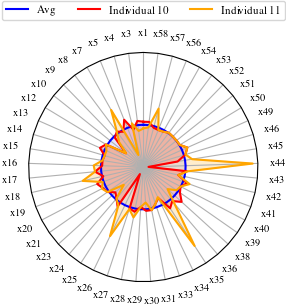

In [36]:
theta = radar_factory(n_feats, frame='polygon')
patient_ids = [10, 11]
# set different patient colors: red and orange
colors = ['r', 'orange']
with plt.rc_context({**bundles.iclr2024()}):
    fig, ax = plt.subplots(subplot_kw=dict(projection='radar'))
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    avg_delta = sum(np.mean(delta_train, axis=0)) * np.ones(n_feats)

    _ = ax.plot(theta, avg_delta, label='Avg', color='b')
    ax.fill(theta, avg_delta, alpha=0.1, color='b')

    avg_delta_ = delta_train.mean(axis=0).values[None, :]
    avg_matrix = np.repeat(avg_delta_, delta_train.shape[1], axis=0)

    for j, patient_id in enumerate(patient_ids):
        np.fill_diagonal(avg_matrix, delta_train.iloc[patient_id].values)
        pat_proba = avg_matrix.sum(axis=1)
        _ = ax.plot(theta, pat_proba, label=f'Individual {patient_id}', color=colors[j])
        ax.fill(theta, pat_proba, alpha=0.2, color=colors[j])

    ax.set_varlabels(cols_delta, fontsize=7.5)
    # legend above the radar plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, fontsize=8)
    plt.tight_layout()
    plt.savefig('../visualization/radar_tkaam.pdf', bbox_inches='tight')
    plt.show()


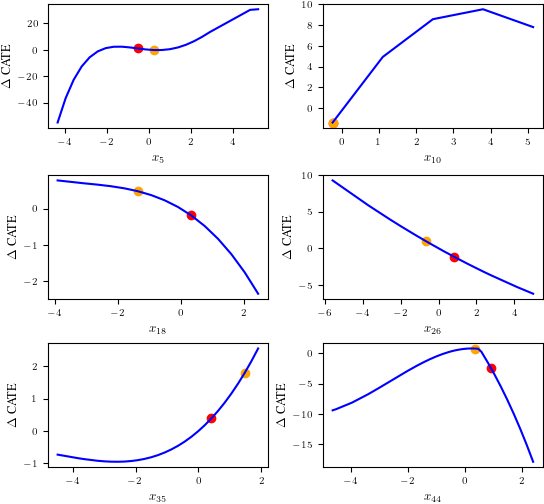

In [37]:
# PDP on each feature
# we will represent only the most important variables based on the radar plot
with plt.rc_context({**bundles.iclr2024(), **figsizes.iclr2024(ncols=2, nrows=3)}):
    #for dataset 3: ['x5', 'x10', 'x18', 'x26', 'x35', 'x44']
    # for dataset 4: ['x4','x13', 'x19', 'x26', 'x37', 'x43']
    important_vars = ['x5', 'x10', 'x18', 'x26', 'x35', 'x44']
    fig, axs = plt.subplots(nrows=3, ncols=2)

    for i, var in enumerate(important_vars):
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        # plot the value of delta_train[var] against x_train_df[var] ordered with plot
        sorted_idx = np.argsort(x_train_df[var])
        ax.plot(x_train_df[var].values[sorted_idx], delta_train[var].values[sorted_idx], color='b')
        # change the name var (format x25) to latex version x_{25}
        var_latex = var.replace('x', 'x_{') + '}'
        ax.set_xlabel(f'${var_latex}$')

        ax.set_ylabel(r'$\Delta$ CATE')

        # represent the points of the patients of patients_id
        for j, patient_id in enumerate(patient_ids):
            ax.scatter(x_train_df[var].values[patient_id], delta_train[var].values[patient_id], color=colors[j], label=f'Patient {patient_id}')

    plt.savefig('../visualization/pdp_tkaam.pdf')
    plt.show()

In [38]:

var = 'x44'
important_vars = ['x5', 'x10', 'x18', 'x26', 'x35', 'x44']
# now include in the same plot, the radar and the pdp of x44, with a shared legend
# the radar must have only ['x5','x7', 'x10', 'x18', 'x26', 'x35', 'x44', 'x57']

with plt.rc_context({**bundles.icml2024(column='full', ncols=2, nrows=1)}):
    fig = plt.figure()
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1.5])
    ax1 = fig.add_subplot(gs[0, 0], projection='radar')  # radar
    ax2 = fig.add_subplot(gs[0, 1])                      # normal
    important_var_index = [i for i, col in enumerate(delta_train.columns) if col in important_vars]
    delta_train_important = delta_train.iloc[:, important_var_index]
    # radar plot
    ax = ax1
    n_feats_radar = len(important_vars)
    theta_radar = radar_factory(n_feats_radar, frame='polygon')
    # ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    avg_delta = sum(np.mean(delta_train_important , axis=0)) * np.ones(n_feats_radar)
    # avg_delta = sum(np.mean(delta_train , axis=0)) * np.ones(n_feats_radar)

    # avg_delta = np.log(avg_delta)
    _ = ax.plot(theta_radar, avg_delta, label='Avg', color='b')
    ax.fill(theta_radar, avg_delta, alpha=0.1, color='b')

    avg_delta_ = delta_train_important .mean(axis=0).values[None, :]
    avg_matrix = np.repeat(avg_delta_, delta_train_important.shape[1], axis=0)

    for j, patient_id in enumerate(patient_ids):
        np.fill_diagonal(avg_matrix, delta_train_important.iloc[patient_id].values)
        pat_proba = avg_matrix.sum(axis=1)
        # pat_proba = np.log(pat_proba)
        _ = ax.plot(theta_radar, pat_proba, label=f'Individual {patient_id}', color=colors[j])
        ax.fill(theta_radar, pat_proba, alpha=0.2, color=colors[j])

    ax.set_varlabels(important_vars)
    # ax.set_title('Radar Plot', fontsize=16)
    # set x axis to logarithmic
    # ax.set_xscale('log')

    # plot the value of delta_train[var] against x_train_df[var] ordered with plot
    sorted_idx = np.argsort(x_train_df[var])
    ax2.plot(x_train_df[var].values[sorted_idx], delta_train_important[var].values[sorted_idx], color='cyan')
    # change the name var (format x25) to latex version x_{25}
    var_latex = var.replace('x', r'x \textsubscript{') + '}'
    ax2.set_xlabel(f'{var_latex}', fontsize=14)

    ax2.set_ylabel(r'$\Delta$ CATE', fontsize=12)

    # represent avg_delta[0] as a horizontal line
    ax2.axhline(y=avg_delta[0], color='b', linestyle='--', label='Avg')


    # add the scatter
    for j, patient_id in enumerate(patient_ids):
        ax2.scatter(x_train_df[var].values[patient_id], delta_train_important[var].values[patient_id], color=colors[j],
                   label=f'Individual {patient_id}')

    handles, labels = ax2.get_legend_handles_labels()


    # put it at the center top, spanning both subplots
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15),
               ncol=3, frameon=False, fontsize=12)
    # plt.tight_layout()
    # represent the points of the patients of patients
    plt.savefig(f'../visualization/all_tkaam_{var}.pdf', bbox_inches='tight')
    plt.show()


ValueError: The number of FixedLocator locations (49), usually from a call to set_ticks, does not match the number of labels (6).

# Radar plot for same patient and two potential outcomes

C:\Users\Alex\AppData\Local\Temp\ipykernel_29132\1443095834.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


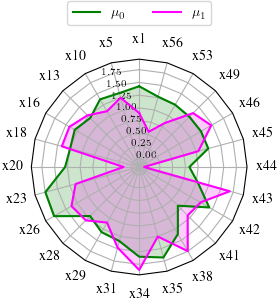

In [132]:
delta_formula_0, delta_train_0 = get_delta(x_train_df, formulas_0[0])
delta_formula_1, delta_train_1 = get_delta(x_train_df, formulas_1[0])

delta_train_0 = delta_train_0[0].iloc[:, :-1]
delta_train_1 = delta_train_1[0].iloc[:, :-1]

cols_delta = list(set(delta_train_0.columns).intersection(delta_train_1.columns))
# modifty cols_delta to be in the same order as x_cols
cols_delta = [col for col in x_cols if col in cols_delta]
index_of_columns = [delta_train_0.columns.get_loc(col) for col in cols_delta]
delta_train_0 = delta_train_0.iloc[index_of_columns, index_of_columns]
delta_train_1 = delta_train_1.iloc[index_of_columns, index_of_columns,]
# delta_factual = delta_factual[cols_delta]
theta = radar_factory(len(cols_delta), frame='polygon')
patient_id = 11
# set different patient colors: red and orange
colors_po = ['g', 'magenta']
with plt.rc_context({**bundles.iclr2024()}):
    fig, ax = plt.subplots(subplot_kw=dict(projection='radar'))
    # ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    avg_delta = sum(np.mean(delta_train_0, axis=0)) * np.ones(len(cols_delta))

    avg_delta_ = delta_train_0.mean(axis=0).values[None, :]
    avg_matrix = np.repeat(avg_delta_, delta_train_0.shape[1], axis=0)


    np.fill_diagonal(avg_matrix, delta_train_0.iloc[patient_id].values)
    pat_proba = avg_matrix.sum(axis=1)
    _ = ax.plot(theta, pat_proba, label=f'$\mu_0$', color=colors_po[0])
    ax.fill(theta, pat_proba, alpha=0.2, color=colors_po[0])

    np.fill_diagonal(avg_matrix, delta_train_1.iloc[patient_id].values)
    pat_proba = avg_matrix.sum(axis=1)
    _ = ax.plot(theta, pat_proba, label=f'$\mu_1$', color=colors_po[1])
    ax.fill(theta, pat_proba, alpha=0.2, color=colors_po[1])

    ax.set_varlabels(cols_delta, fontsize=10)
    # legend above the radar plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), fontsize=10, ncol=2)
    plt.tight_layout()
    plt.savefig('../visualization/radar_tkaam_potential.pdf', bbox_inches='tight')
    plt.show()

## Formulas in standard autosymbolic substitution

In [96]:
tic = time.time()
formula_2 = t_kaam.interprete(lib='all', n_digit=4)
tac = time.time()
print('FITTING TIME STANDARD', tac - tic)

Using library all
skipping (0,0,0) since already symbolic
skipping (0,1,0) since already symbolic
skipping (0,2,0) since already symbolic
skipping (0,3,0) since already symbolic
skipping (0,4,0) since already symbolic
skipping (0,5,0) since already symbolic
skipping (0,6,0) since already symbolic
skipping (0,7,0) since already symbolic
skipping (0,8,0) since already symbolic
skipping (0,9,0) since already symbolic
skipping (0,10,0) since already symbolic
skipping (0,11,0) since already symbolic
skipping (0,12,0) since already symbolic
skipping (0,13,0) since already symbolic
skipping (0,14,0) since already symbolic
skipping (0,15,0) since already symbolic
skipping (0,16,0) since already symbolic
skipping (0,17,0) since already symbolic
skipping (0,18,0) since already symbolic
skipping (0,19,0) since already symbolic
skipping (0,20,0) since already symbolic
skipping (0,21,0) since already symbolic
skipping (0,22,0) since already symbolic
skipping (0,23,0) since already symbolic
skipping

In [97]:
cate_formula_2 = formula_2[1] - formula_2[0]
print(cate_formula_2)

-0.5876*x_17 - 0.1628*x_20 + 0.2555*x_21 - 1.4113*x_26 + 0.1011*x_27 + 0.2771*x_29 - 0.2495*x_31 + 0.5445*x_33 + 0.1498*x_34 + 0.3418*x_35 + 0.2207*x_36 - 0.2966*x_38 - 0.3245*x_40 + 0.0176*x_43 - 1.6682*x_44 - 0.4033*x_45 + 0.6473*x_5 - 0.1224*x_51 - 0.5669*x_53 + 0.4184*x_54 - 0.0195*x_55 - 0.4025*x_58 - 0.0003*(1.1668 - 9.048*x_50)**2 + 0.012*(3.951 - 3.9794*x_16)**2 - 0.0041*(5.6153 - 7.8012*x_41)**2 - 0.1917*(6.5454 - 1.7803*x_10)**2 - 0.0226*(7.6625 - 2.4173*x_10)**2 + 0.0098*(9.4713 - 3.8174*x_52)**2 + 0.0031*(9.7966 - 4.9687*x_46)**2 + 0.0048*(-2.0486*x_16 - 5.9465)**2 - 0.003*(-9.3034*x_23 - 2.3756)**2 + 0.1204*sqrt(5.2894*x_31 + 2.5432) - 0.0021*(-8.3828*x_39 - 5.7947)**2 - 1.0336*exp(0.5962*x_18) - 0.2271*exp(0.9656*x_24) - 0.5315*exp(0.5566*x_34) + 0.4737*exp(0.868*x_35) + 1.1177*sin(0.6334*x_1 - 7.197) - 0.4008*sin(0.8105*x_1 - 0.8086) - 0.2414*sin(4.8782*x_12 + 1.297) - 0.4019*sin(0.8307*x_13 - 1.0168) + 1.0944*sin(5.1933*x_13 + 5.1912) - 0.3325*sin(1.8123*x_14 + 2.3598) 

We observe that the obtained formula is much more complex than the one obtained by us, while we achieve good performance and more interpretability.